# Tikhonov extraction
### Reminder:
- The extraction method (called the engine) tries to simultaneously fit the flux at both orders by solving the system of equation 
\begin{equation}
    \left(\frac{\textbf{D}}{\mathbf{\sigma}}\right)_{1 \times \rm N_i}     \left(\frac{\textbf{B}}{\mathbf{\sigma}}\right)_{\rm N_i \times N_k}
    = \left(\frac{\textbf{B}}{\mathbf{\sigma}}\right)_{\rm N_k \times N_i}^T
      \left(\frac{\textbf{B}}{\mathbf{\sigma}}\right)_{\rm N_i \times N_k}
      \mathbf{f}_{\rm N_k}
\end{equation}
where $\textbf{D}$ and $\sigma$ are respectilvely the intensity measurement and the error estimate at each pixel. $\textbf{B}$ is the matrix that reprensents the model of each pixels given by $\textbf{B}_{N_i \times N_k} \textbf{f}_{N_k} = \textbf{B} \cdot \textbf{f}_{k}$. Here, $\textbf{f}_{k}$ is the non convolved flux projected on the specified wavelength grid and that is what we want to determine. We therefore have to solve a system of the form $\textbf{Ax}=\textbf{b}$

### 1. Why Tikhonov?
- To be able to fit precisely the the detector's pixels, we need to oversample $\textbf{f}_{k}$.
- However, the more we oversample, the more the solution becomes degenerate. This will results in an ill-conditionned problem, causing big instabilities in the solution, ultimately leading to a singular matrix (unsolvable)
- Tikhonov regularisation enables to lift this degeneracy by adding an additionnal constraint on the solution.

### 2. How? (See [Wikipedia](https://en.wikipedia.org/wiki/Tikhonov_regularization) for more precise informations)
- Solving the linear system $\textbf{Ax}=\textbf{b}$ can be done by minimizing the norm of the vector $\|\textbf{Ax}-\textbf{b}\|^2_2$ when the solution exists. Tikhonov regularisation proposes to add the term $\|\alpha \Gamma \textbf{x}\|^2_2$, where $\alpha$ is a simply a scale factor (scalar) and $\Gamma$ is the Tikhonov matrix. Hence, the equation to minimize is given by $\|\textbf{Ax}-\textbf{b}\|^2_2 + \|\alpha \Gamma \textbf{x}\|^2_2$, which can be re-write as 
\begin{equation}
(\textbf{A}^\mathrm{T}\textbf{A}+\alpha^2\Gamma^\mathrm{T}\Gamma)\,\textbf{x}=\textbf{A}^\mathrm{T}\textbf{b}
\end{equation}
- The Tikhonov matrix depends on the desirable proporties of the solution and there are many different ways to define it. In this case, we propose to pull the solution towards a solution with a resolution n times higher than that of the most precise order (order 2 in this case). In other words, we force the solution to be closed to the convolved solution. Mathematically, if the convolved flux at the required resolution is given by $\textbf{C}_R\cdot \textbf{f}_{k}$ where $\textbf{C}_R$ is the convolution matrix at resolution $R$, then the tikhonov matrix is given by 
\begin{equation}
\Gamma = \textbf{C}_R - \textbf{I},
\end{equation}
$\textbf{I}$ being the identity matrix. Therefore, $\Gamma \cdot \textbf{f}_{k} = \textbf{C}_R \cdot \textbf{f}_{k} - \textbf{f}_{k}$

# Examples

In [1]:
# Imports for plots

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

%matplotlib notebook

plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

# Imports froom standard packages

from scipy.interpolate import interp1d
from astropy.io import fits
import numpy as np

# Imports for extraction

from extract.overlap import TrpzOverlap

# Local imports

from simulation_utils import load_simu, add_noise

## Load ref files

In [2]:
DEFAULT_PATH = '../jwst-mtl/SOSS/extract/'
DEFAULT_REF_FILES = {'wv_1': 'Ref_files/wavelengths_m1.fits',
                     'wv_2': 'Ref_files/wavelengths_m2.fits',
                     'P_1': 'Ref_files/spat_profile_m1.fits',
                     'P_2': 'Ref_files/spat_profile_m2.fits'}

# Read relevant files
wv_1 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["wv_1"])[0].data
wv_2 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["wv_2"])[0].data
P1 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["P_1"])[0].data.squeeze()
P2 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["P_2"])[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
P1 = P1.astype(float)
P2 = P2.astype(float)

## 1. The instability

In [3]:
# Load a simulation
simu = load_simu("../Simulations/phoenix_teff_02300_scale_1.0e+08.fits")
scidata = simu["data"]
sig = np.sqrt(scidata + 20.**2)  # Map of expected noise

In [5]:
# Extract
extra = TrpzOverlap([P1,P2], [wv_1,wv_2], data=data, n_os=5,
                    thresh=1e-4, c_kwargs={'thresh':1e-5}, sig=sig)
f_k = extra.extract()

NameError: name 'data' is not defined

### Convolved flux
We can se the big instability problem

<IPython.core.display.Javascript object>


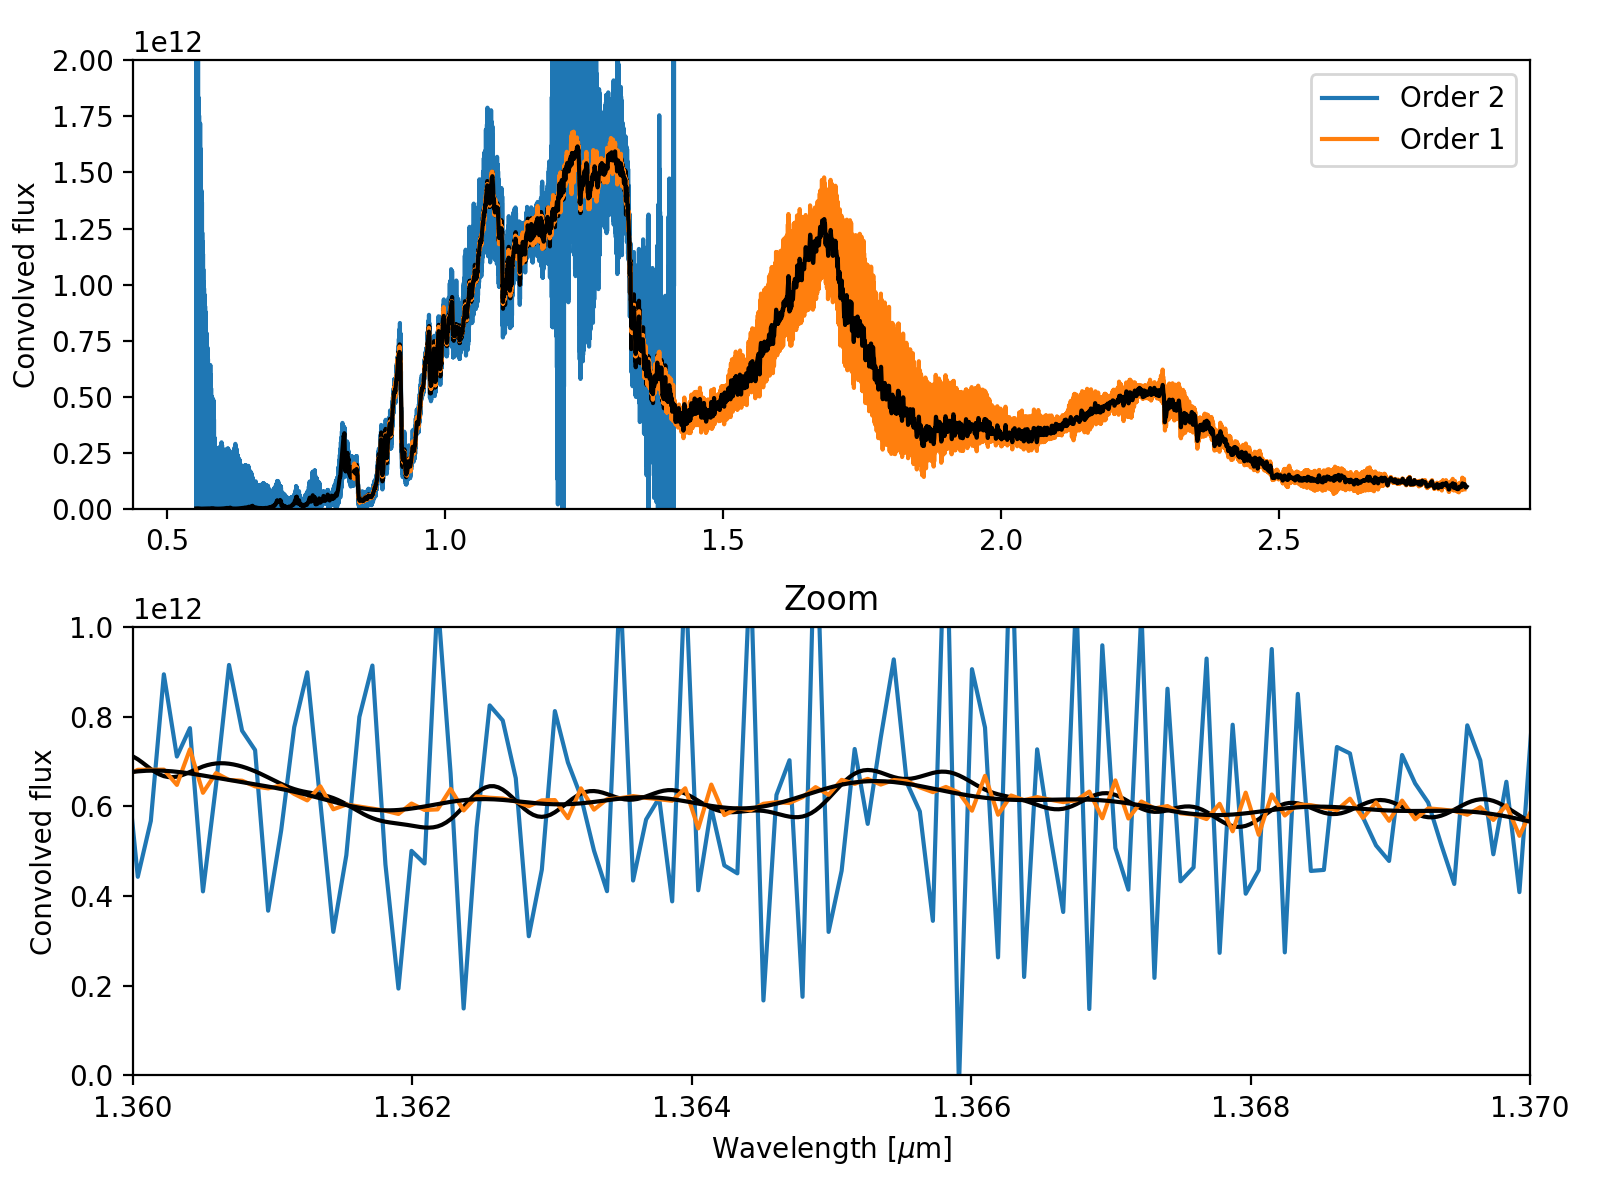

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

for i_ord in [1, 0]:
    
    f_k_th = simu[f"f_c{i_ord + 1}"]
    grid_th = simu[f"grid_c{i_ord + 1}"]
    

    ax[0].plot(extra.lam_grid_c(i_ord), extra.c_list[i_ord].dot(f_k), label=f"Order {i_ord + 1}")
    ax[0].plot(grid_th, f_k_th, "k")
    
    ax[1].plot(extra.lam_grid_c(i_ord), extra.c_list[i_ord].dot(f_k), label=f"Order {i_ord + 1}")
    ax[1].plot(grid_th, f_k_th, "k")
    
ax[0].legend()
ax[0].set_ylim(0, 2e12)
ax[1].set_ylim(0, 1e12)
ax[1].set_xlim(1.36, 1.37)
plt.xlabel("Wavelength [$\mu$m]")
ax[0].set_ylabel("Convolved flux")
ax[1].set_ylabel("Convolved flux")
ax[1].set_title("Zoom")
plt.tight_layout()

### Binned to pixels
The instability is not visible after binning, but it affects the precision

<IPython.core.display.Javascript object>


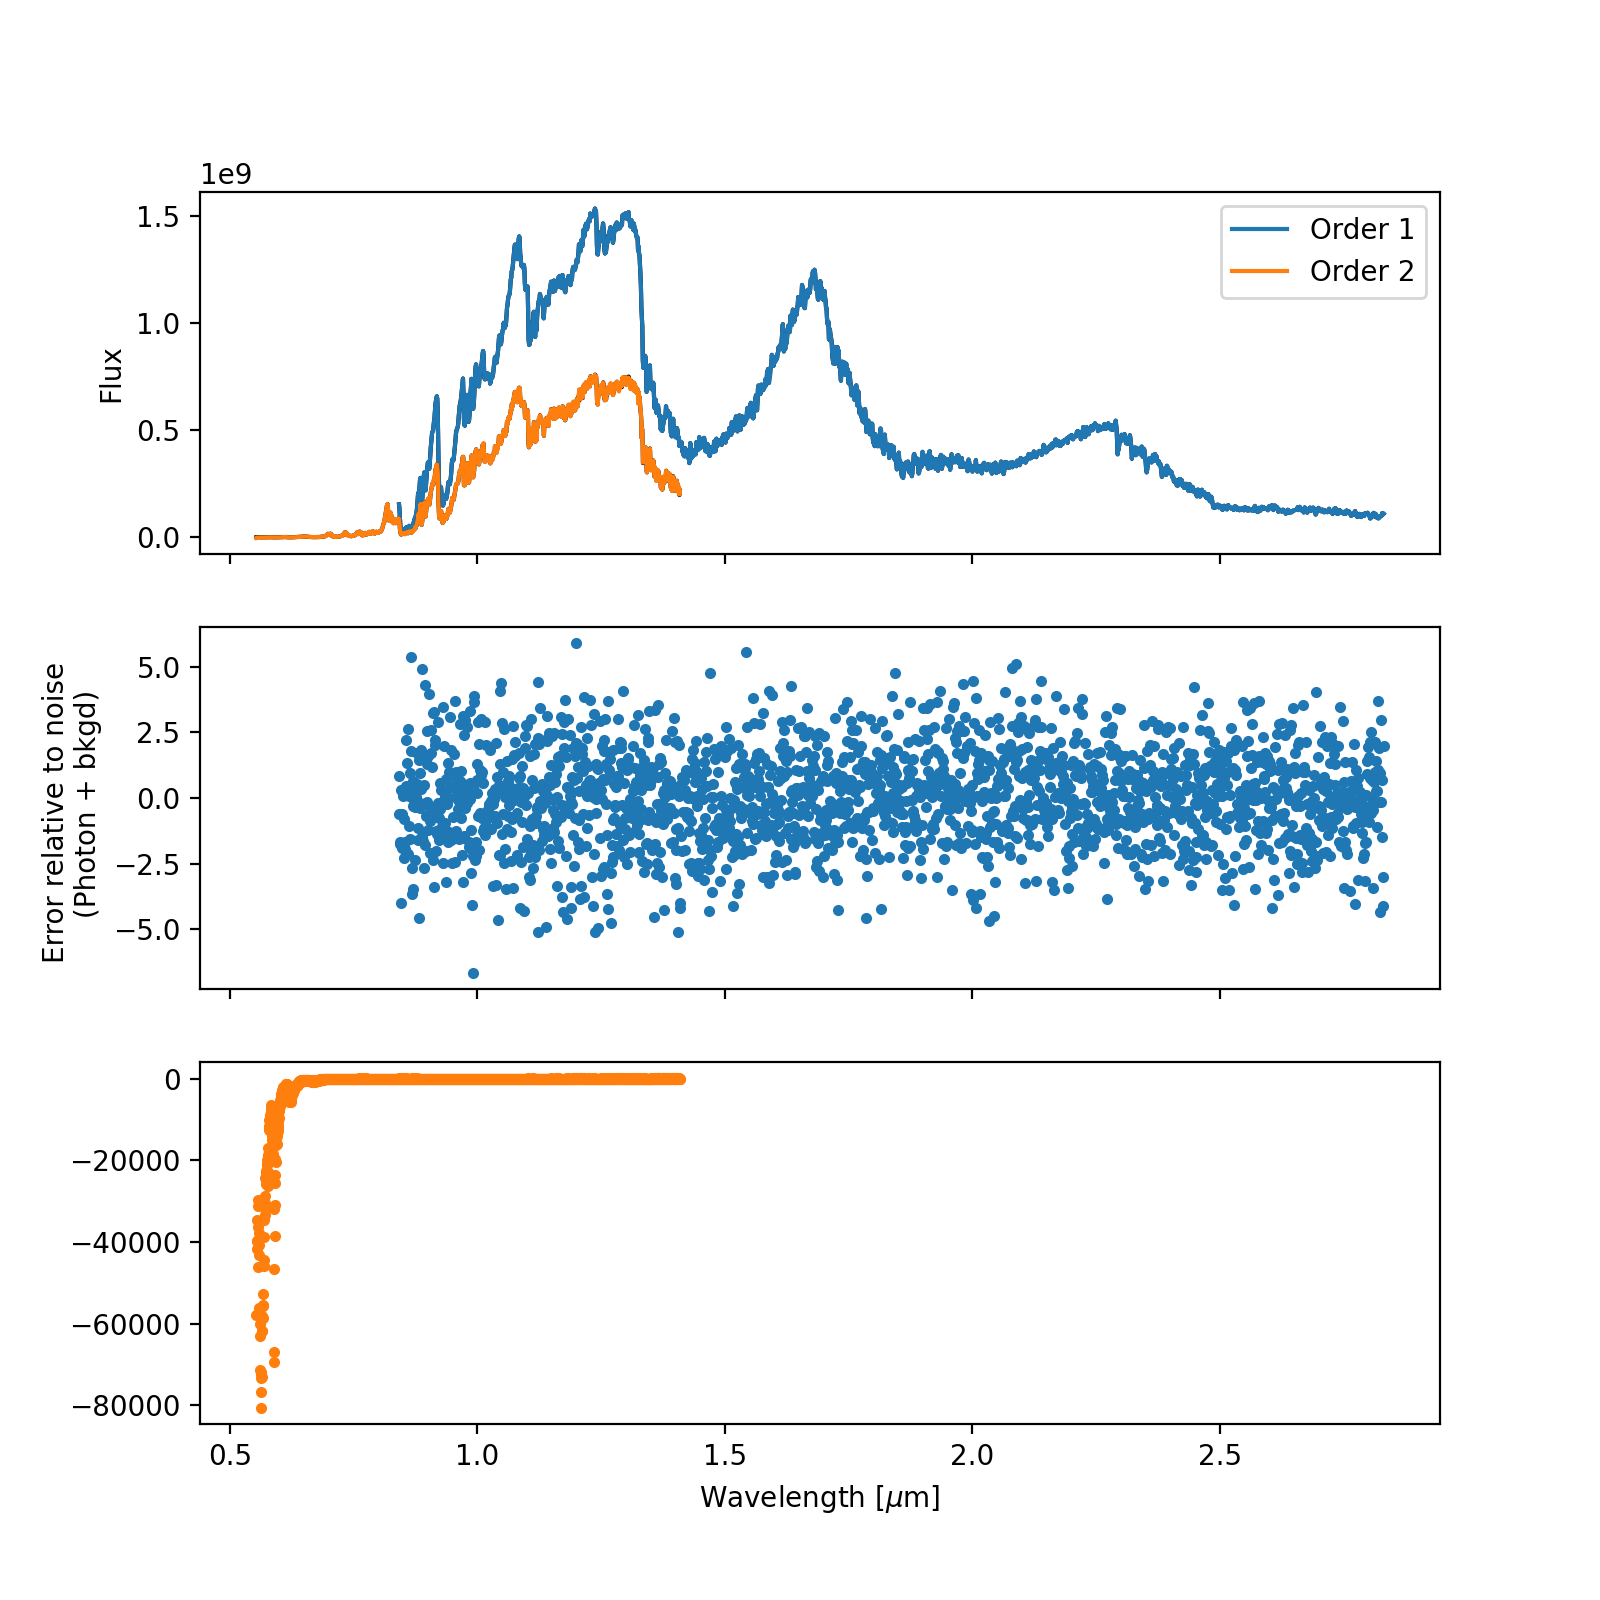

<IPython.core.display.Javascript object>


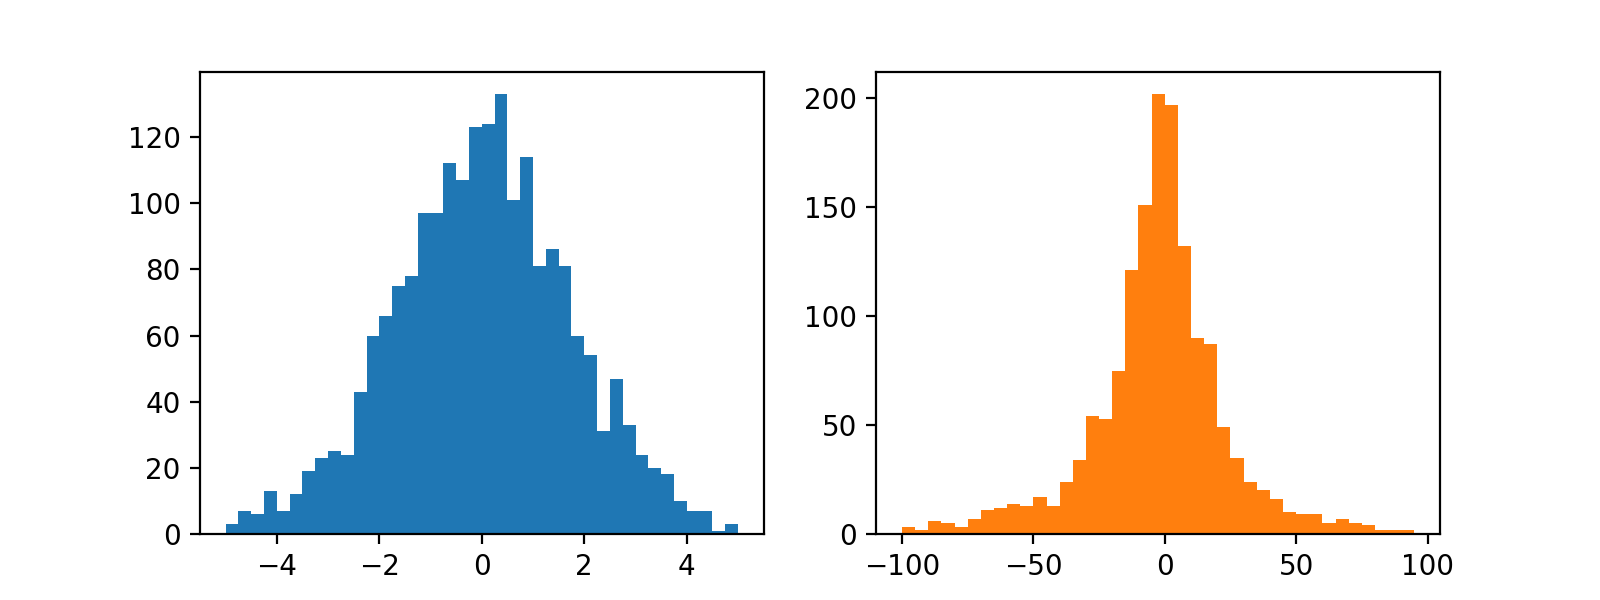

Text(0.5, 0, 'Wavelength [$\\mu$m]')

In [13]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

fig_bin, ax_bin = plt.subplots(1, 2, figsize=(8, 3))
bin_lim = [np.arange(-5, 5.2, 0.25), np.arange(-100, 100, 5)]
# bin_lim[1] = np.concatenate([[-5000], bin_lim[1],[5000.]])

for i_ord in range(extra.n_ord):

    lam_bin, f_bin = extra.bin_to_pixel(f_k=f_k, i_ord=i_ord)
    f_k_th = simu[f"f_c{i_ord + 1}"]
    grid_th = simu[f"grid_c{i_ord + 1}"]
    f_th_bin = extra.bin_to_pixel(f_k_c=f_k_th, grid_f_k=grid_th, grid_pix=lam_bin)[1]
    bin_err = interp1d(*extra.estim_noise(i_ord=i_ord), bounds_error=False)
    
    ax[0].plot(lam_bin, f_th_bin, "k")
    ax[0].plot(lam_bin, f_bin, label=f"Order {i_ord + 1}")

    color = ax[0].get_lines()[-1].get_color()
    ax[1 + i_ord].plot(lam_bin, (f_bin-f_th_bin)/f_th_bin/bin_err(lam_bin), ".", color=color)
    
    ax_bin[i_ord].hist((f_bin-f_th_bin)/f_th_bin/bin_err(lam_bin), bins=bin_lim[i_ord], color=color)
    
ax[0].legend()
ax[0].set_ylabel("Flux")
ax[1].set_ylabel("Error relative to noise \n (Photon + bkgd)")
ax[-1].set_xlabel("Wavelength [$\mu$m]")

### To better estimate the error, we can run a set of simulations with varying noise and compute the standard deviation

In [6]:
simu_clean = load_simu("../Simulations/phoenix_teff_02300_scale_1.0e+02.fits", noisy=False)

In [160]:
f_bin_list = [[] for i_ord in range(extra.n_ord)]
lam_bin = [None for i_ord in range(extra.n_ord)]

for it in range(50):
    print(it, end="\r")
    
    scidata = add_noise(simu_clean["data"])
    sig = np.sqrt(scidata + 20.**2)  # Map of expected noise
    
    f_k = extra.extract(data=scidata, sig=sig)
    
    for i_ord in range(extra.n_ord):
        if it == 0:
            lam_bin_ord, f_bin = extra.bin_to_pixel(f_k=f_k, i_ord=i_ord)
            lam_bin[i_ord] = lam_bin_ord
        else:
            _, f_bin = extra.bin_to_pixel(f_k=f_k, i_ord=i_ord, grid_pix=lam_bin[i_ord])
        
        f_bin_list[i_ord].append(f_bin)
        
print("Done")

Done


<IPython.core.display.Javascript object>


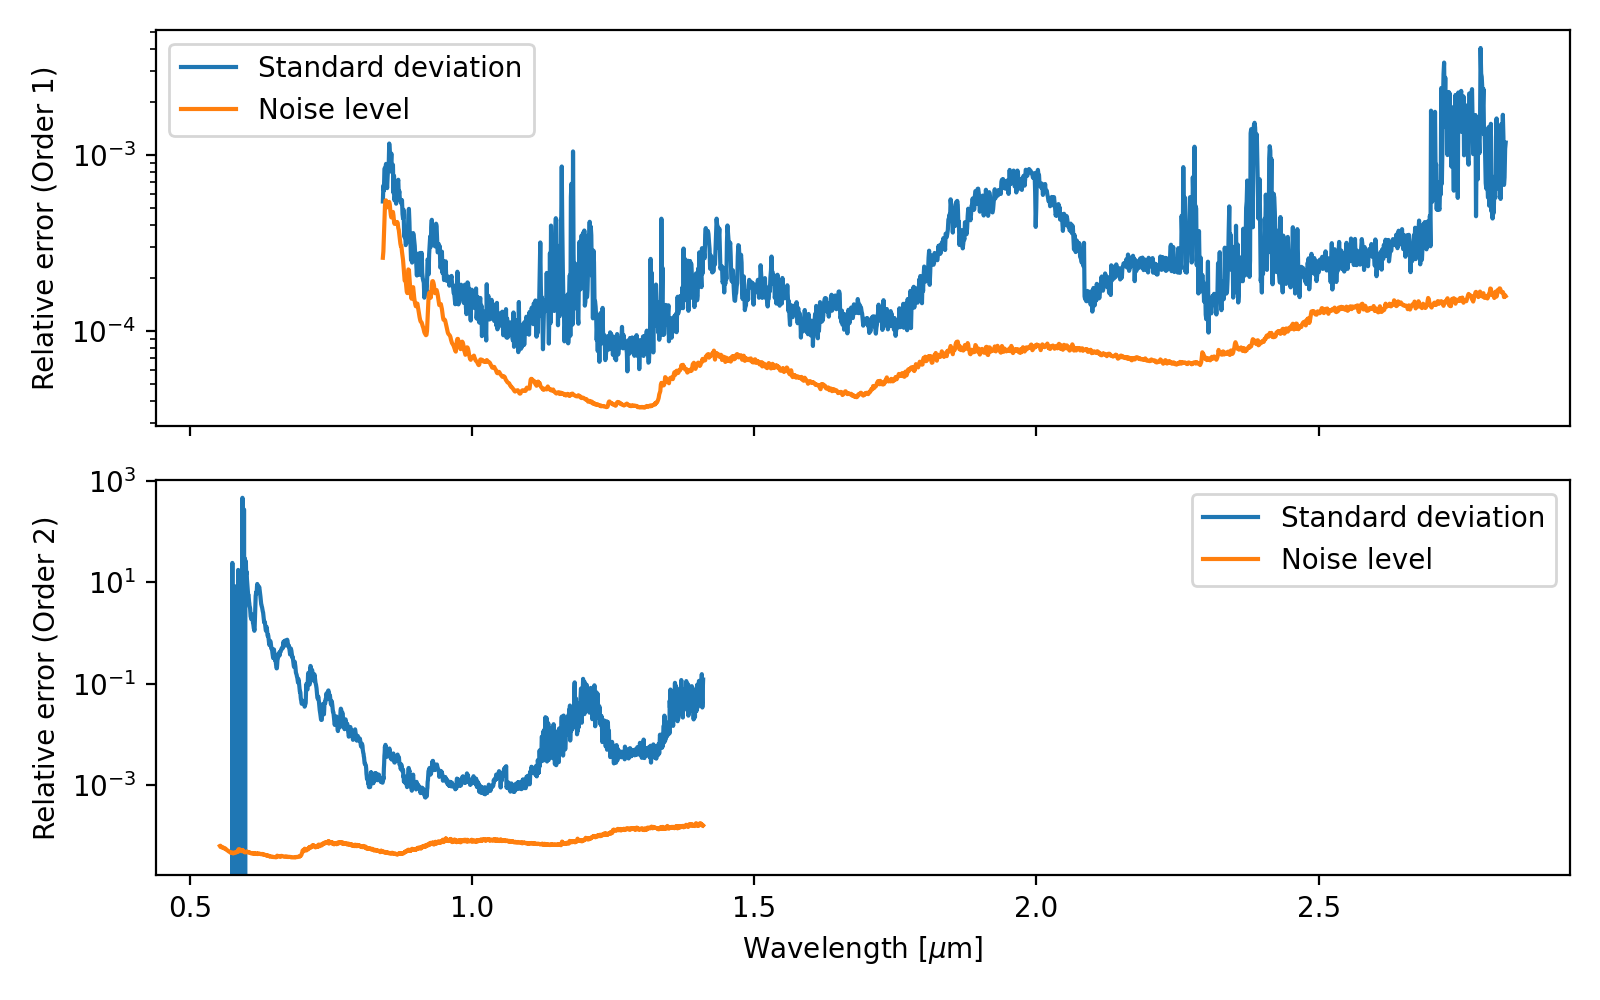

In [161]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

for i_ord in range(extra.n_ord):
    error =  np.std(f_bin_list[i_ord], axis=0) / np.mean(f_bin_list[i_ord], axis=0)
    ax[i_ord].semilogy(lam_bin[i_ord], error, label="Standard deviation")
    ax[i_ord].semilogy(*extra.estim_noise(i_ord=i_ord), label="Noise level")
    ax[i_ord].set_ylabel(f"Relative error (Order {i_ord + 1})")
    ax[i_ord].legend()
    
plt.xlabel("Wavelength [$\mu$m]")
plt.tight_layout()

## 2. Same example using Tikhonov

### Fisrt we have to find the best scale factor

In [6]:
# from extract.regularisation import get_nyquist_matrix

In [177]:
# t_mat = get_nyquist_matrix(extra.lam_grid, integrate=False)

In [168]:
factors = 10.**(-1*np.arange(19, 35, 0.3))
tests = extra.get_tikho_tests(factors)

Testing factors...
54/54


<IPython.core.display.Javascript object>


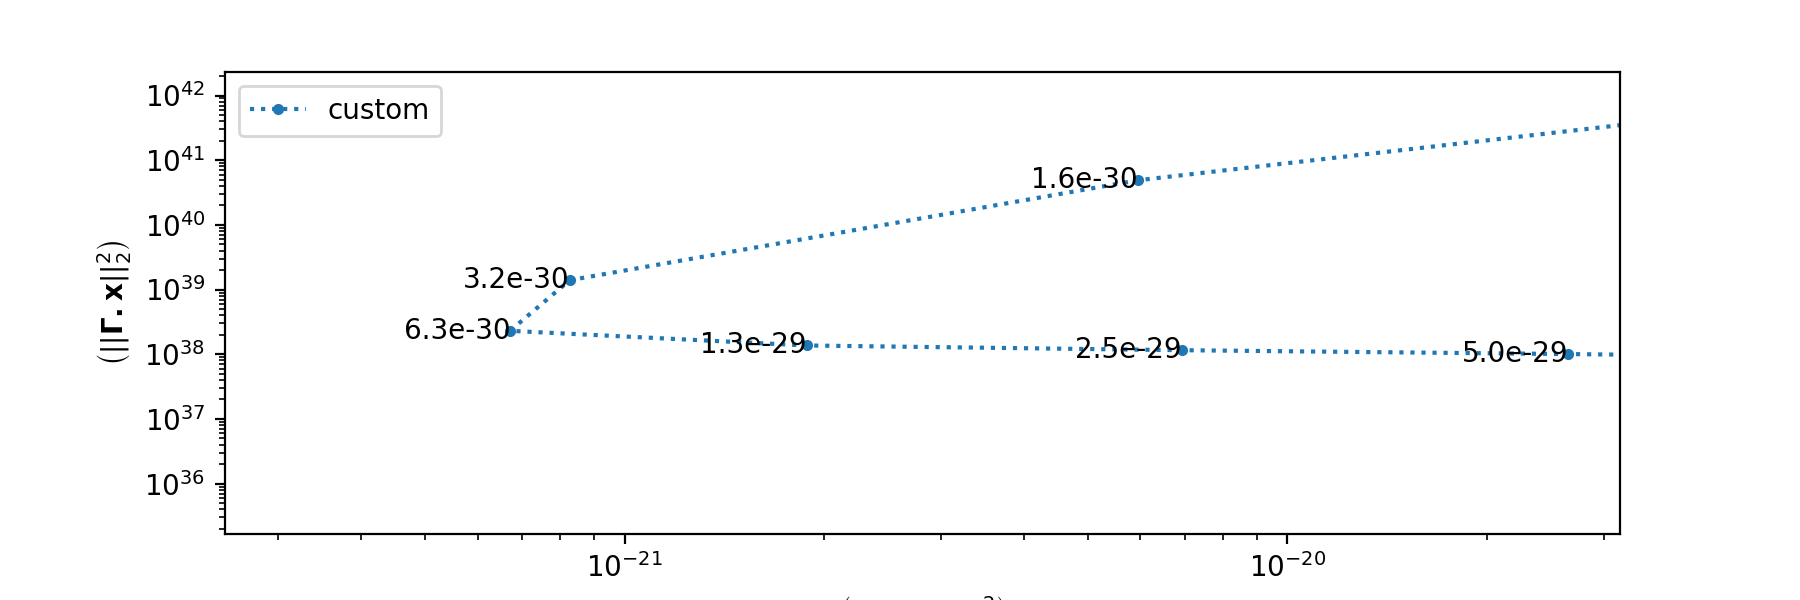

In [169]:
fig, ax = extra.tikho.l_plot(factor_norm=False)
bissec = np.linspace(*np.log10(ax.get_xlim()), 10)
bissec = 10**bissec
# ax.plot(bissec, bissec, "--")



<IPython.core.display.Javascript object>


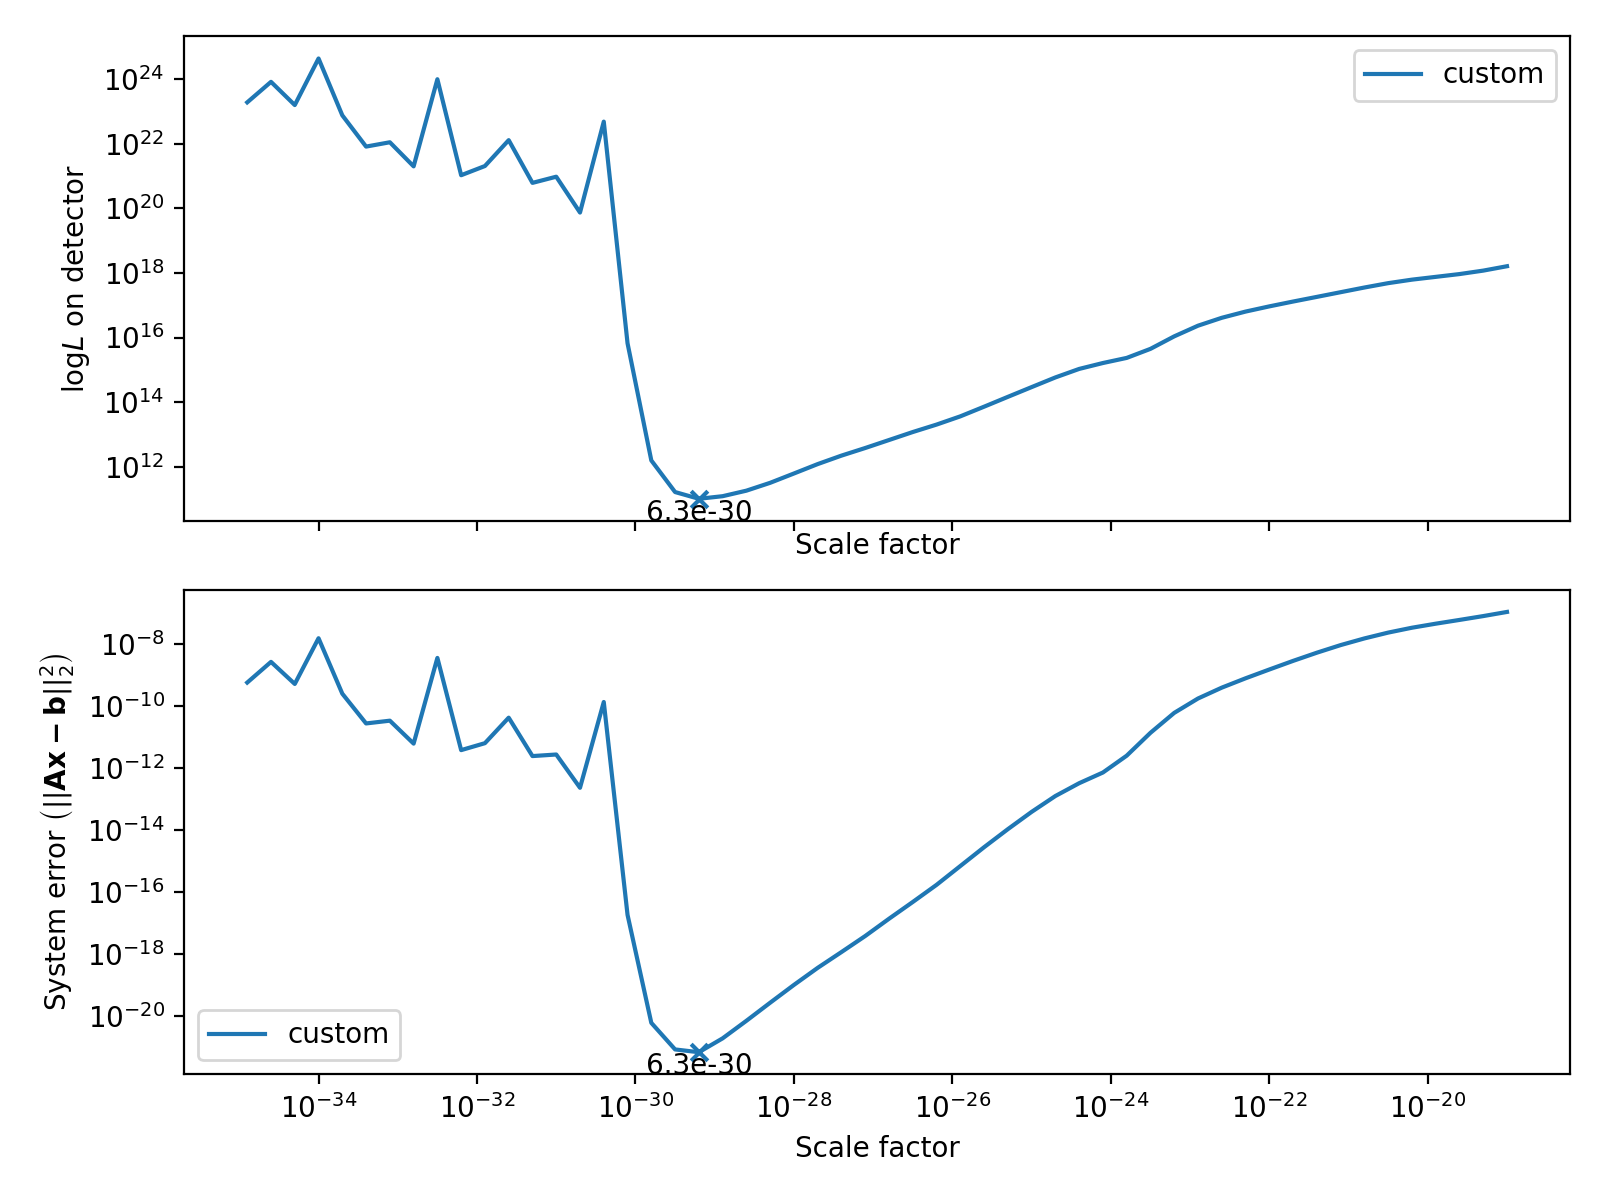

(<Figure size 800x600 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x172b959f10>,
       dtype=object))

In [170]:
extra.plot_tikho_factors()

In [7]:
f_k = extra.extract(tikhonov=True, factor=5.78e-24)

### Nyquist flux

In [158]:
from scipy.sparse import identity

<IPython.core.display.Javascript object>


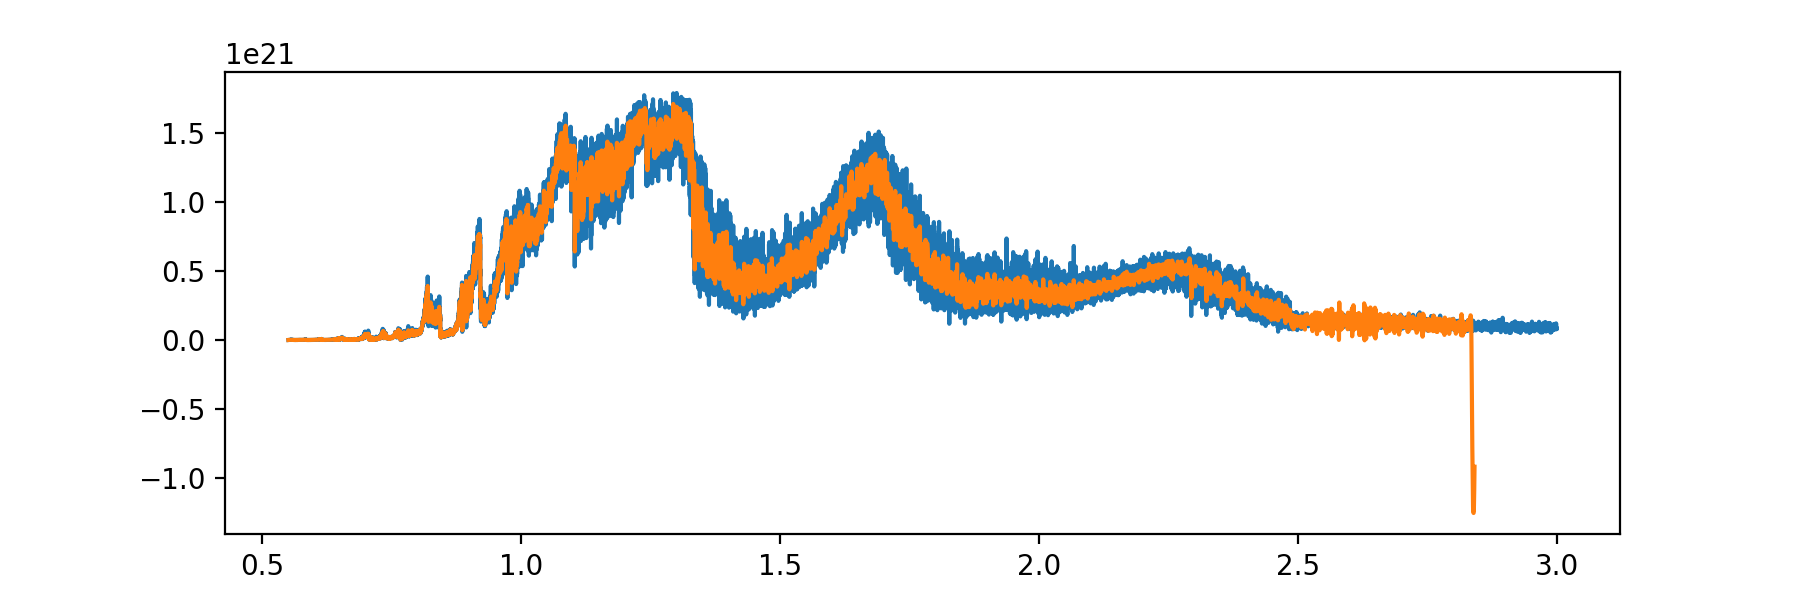

In [165]:



c_nyquist = get_nyquist_matrix(extra.lam_grid, integrate=False) + identity(len(extra.lam_grid))
plt.plot(extra.lam_grid, c_nyquist.dot(f_k))

### Convolved flux

<IPython.core.display.Javascript object>


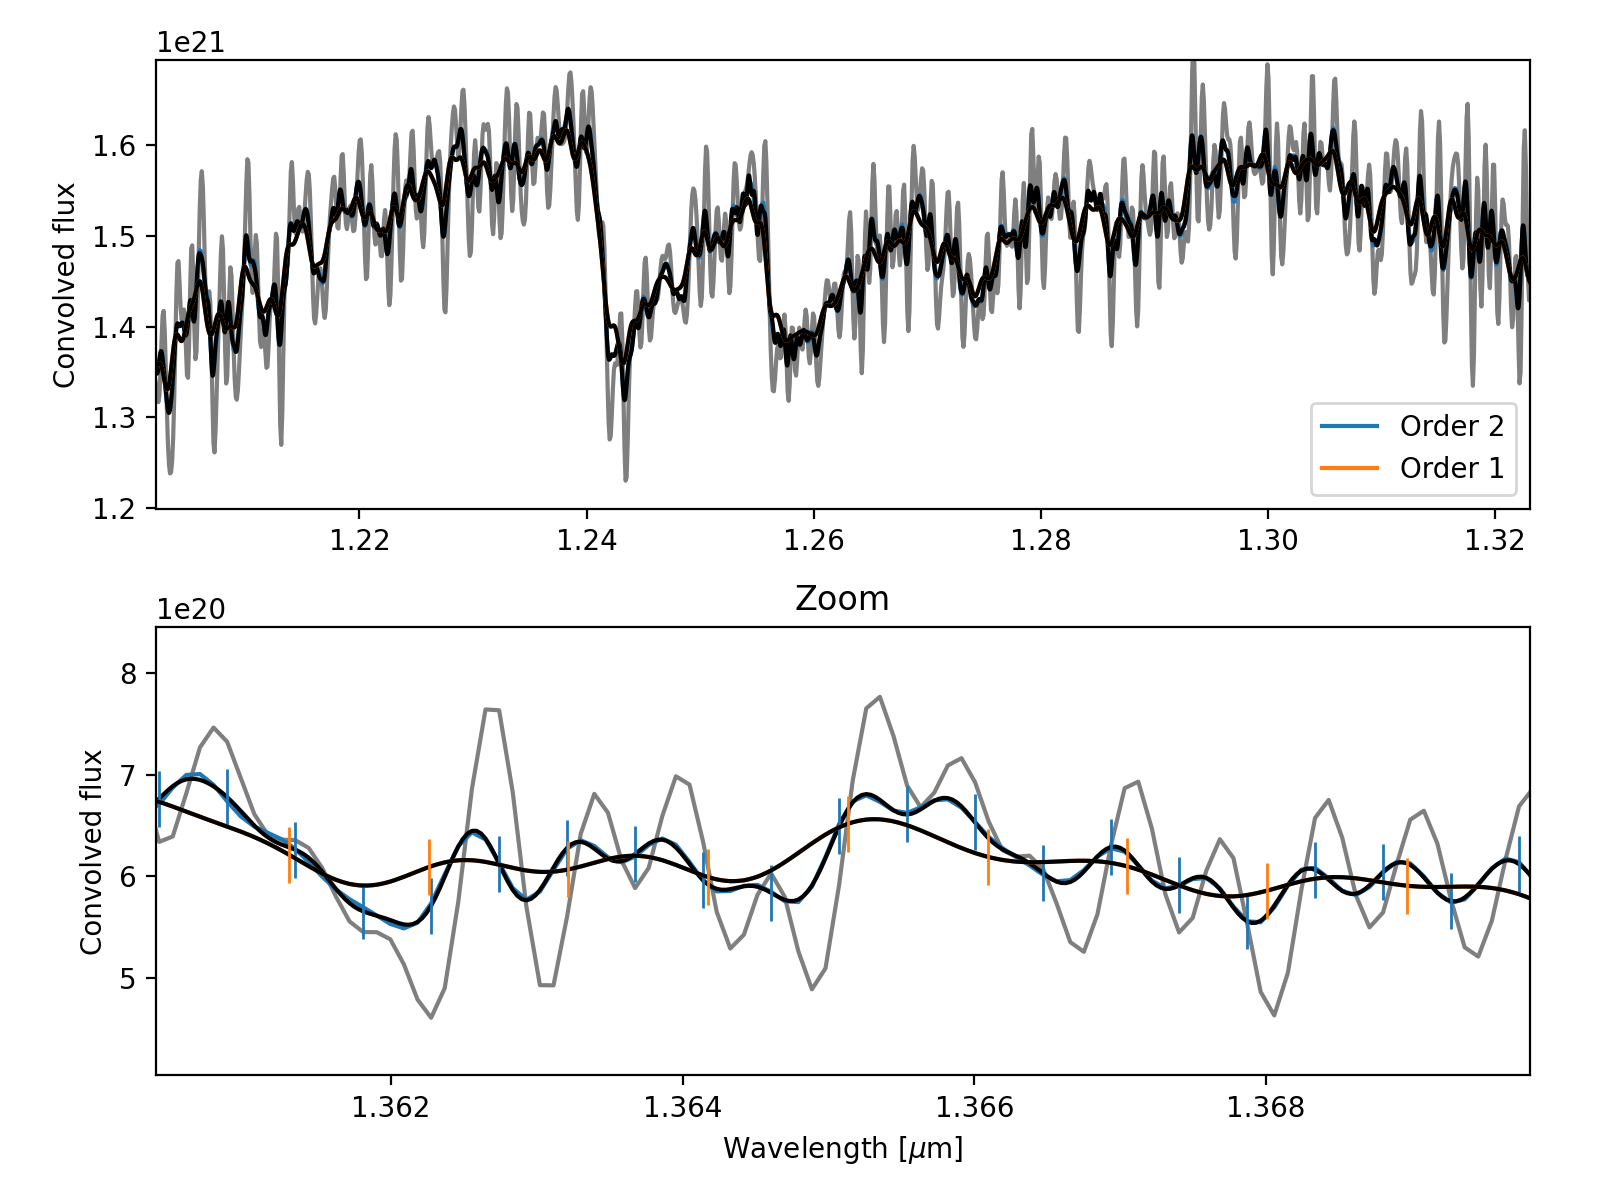

In [166]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

c_nyquist = get_nyquist_matrix(extra.lam_grid, integrate=False) + identity(len(extra.lam_grid))
[ax_i.plot(extra.lam_grid, c_nyquist.dot(f_k), "k", alpha=0.5) for ax_i in ax]

for i_ord in [1, 0]:
    
    f_k_th = simu[f"f_c{i_ord + 1}"]
    grid_th = simu[f"grid_c{i_ord + 1}"]
    fct_f_k = interp1d(grid_th, f_k_th, bounds_error=False)

    ax[0].plot(extra.lam_grid_c(i_ord), extra.c_list[i_ord].dot(f_k), label=f"Order {i_ord + 1}")
    ax[0].plot(grid_th, f_k_th, "k")
    
    ax[1].plot(extra.lam_grid_c(i_ord), extra.c_list[i_ord].dot(f_k), label=f"Order {i_ord + 1}")
    ax[1].plot(grid_th, f_k_th, "k")
    
    # Show bin size
    lam_bin, _ = extra.bin_to_pixel(f_k=f_k, i_ord=i_ord)
    color = ax[1].get_lines()[-2].get_color()
    ax[1].plot(lam_bin, fct_f_k(lam_bin), "|", color=color, ms=20.)
    
    
ax[0].legend()
# ax[0].set_ylim(0, 2e12)
# ax[1].set_ylim(0, 2e12)
ax[1].set_xlim(1.36, 1.37)
plt.xlabel("Wavelength [$\mu$m]")
ax[0].set_ylabel("Convolved flux")
ax[1].set_ylabel("Convolved flux")
ax[1].set_title("Zoom")
plt.tight_layout()

### Binned to pixels

<IPython.core.display.Javascript object>


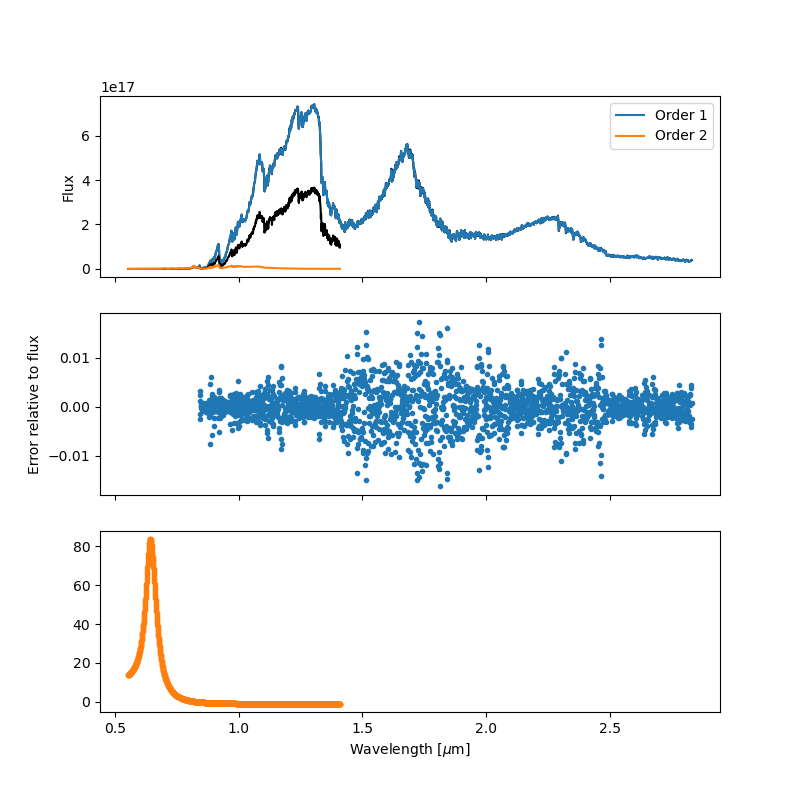

<IPython.core.display.Javascript object>


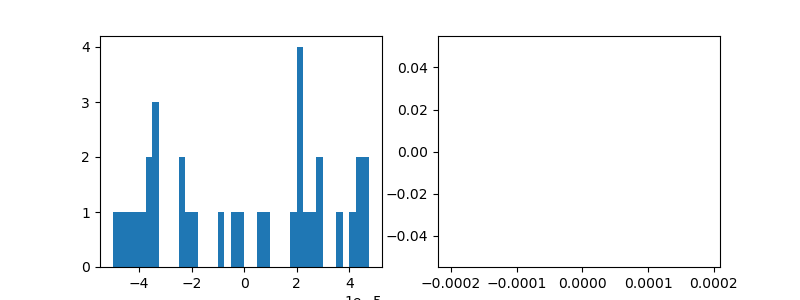

Text(0.5, 0, 'Wavelength [$\\mu$m]')

In [9]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

fig_bin, ax_bin = plt.subplots(1, 2, figsize=(8, 3))
bin_lim = [np.arange(-5e-5, 5e-5, 0.25e-5), np.arange(-2e-4, 2e-4, 0.1e-4)]

for i_ord in range(extra.n_ord):

#     trput = ThroughputSOSS(extra.orders[i_ord])
    lam_bin, f_bin = extra.bin_to_pixel(f_k=f_k, i_ord=i_ord)
    f_k_th = simu[f"f_c{i_ord + 1}"]
    grid_th = simu[f"grid_c{i_ord + 1}"]
    f_th_bin = extra.bin_to_pixel(f_k_c=f_k_th, grid_f_k=grid_th, grid_pix=lam_bin)[1]
#     bin_err = interp1d(*extra.estim_noise(i_ord=i_ord), bounds_error=False)
    
    ax[0].plot(lam_bin, f_th_bin, "k")
    ax[0].plot(lam_bin, f_bin, label=f"Order {i_ord + 1}")

    color = ax[0].get_lines()[-1].get_color()
    ax[1+i_ord].plot(lam_bin, (f_bin-f_th_bin)/f_th_bin, ".", color=color)
    
    ax_bin[i_ord].hist((f_bin-f_th_bin)/f_th_bin, bins=bin_lim[i_ord], color=color)
    
ax[0].legend()
ax[0].set_ylabel("Flux")
ax[1].set_ylabel("Error relative to flux")
ax[-1].set_xlabel("Wavelength [$\mu$m]")

<IPython.core.display.Javascript object>


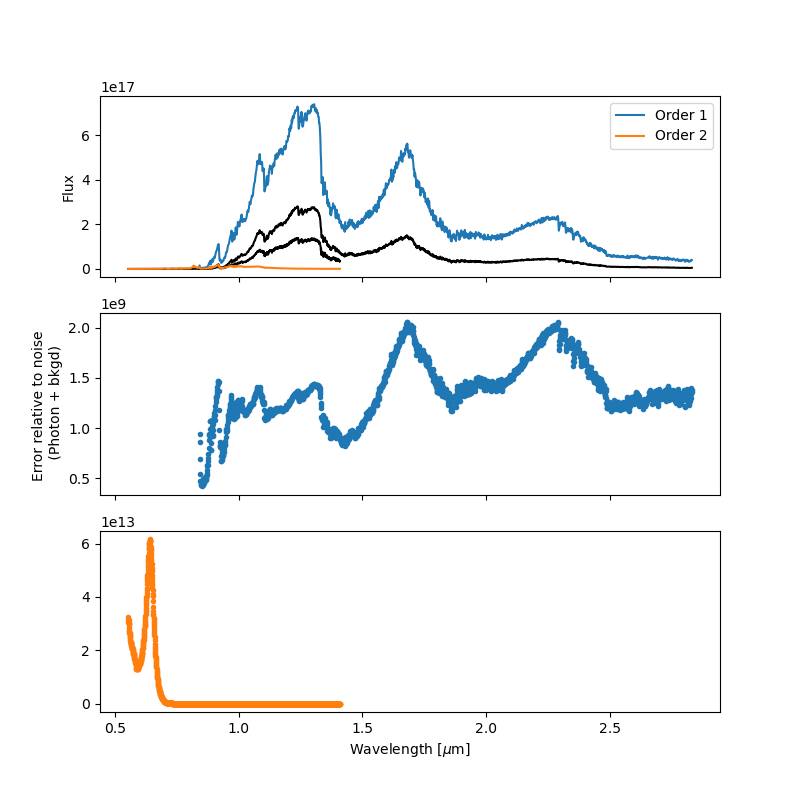

<IPython.core.display.Javascript object>


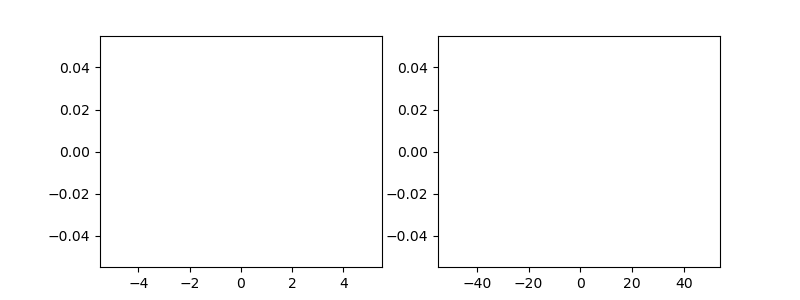

Text(0.5, 0, 'Wavelength [$\\mu$m]')

In [10]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

fig_bin, ax_bin = plt.subplots(1, 2, figsize=(8, 3))
bin_lim = [np.arange(-5, 5.2, 0.25), np.arange(-50, 50, 1)]

for i_ord in range(extra.n_ord):

    lam_bin, f_bin = extra.bin_to_pixel(f_k=f_k, i_ord=i_ord)
    f_k_th = simu[f"f_c{i_ord + 1}"]
    grid_th = simu[f"grid_c{i_ord + 1}"]
    f_th_bin = extra.bin_to_pixel(f_k_c=f_k_th, grid_f_k=grid_th, grid_pix=lam_bin)[1]
    bin_err = interp1d(*extra.estim_noise(i_ord=i_ord), bounds_error=False)
    
    ax[0].plot(lam_bin, f_th_bin, "k")
    ax[0].plot(lam_bin, f_bin, label=f"Order {i_ord + 1}")

    color = ax[0].get_lines()[-1].get_color()
    ax[1+i_ord].plot(lam_bin, (f_bin-f_th_bin)/f_th_bin/bin_err(lam_bin), ".", color=color)
    
    ax_bin[i_ord].hist((f_bin-f_th_bin)/f_th_bin/bin_err(lam_bin), bins=bin_lim[i_ord], color=color)
    
ax[0].legend()
ax[0].set_ylabel("Flux")
ax[1].set_ylabel("Error relative to noise \n (Photon + bkgd)")
ax[-1].set_xlabel("Wavelength [$\mu$m]")

### Plot error indices for each factors

In [132]:
i_factor = (3e-32 < tests["factors"]) & (tests["factors"] < 1e-28)
print("N factor: ", i_factor.sum())

N factor:  12


In [133]:
f_k_list = tests["solution"][i_factor, :]
err_bin_list = [[] for i_ord in range(extra.n_ord)]
lam_bin = [None for i_ord in range(extra.n_ord)]

for i_ord in range(extra.n_ord):
    ifirst = True
    for f_k in f_k_list:
        f_k_c = extra.c_list[i_ord][:, tests["i_grid"]].dot(f_k)
        if ifirst:
            lam_bin_ord, f_bin = extra.bin_to_pixel(f_k_c=f_k_c, i_ord=i_ord)
            lam_bin[i_ord] = lam_bin_ord
            ifirst = False
            f_k_th = simu[f"f_c{i_ord + 1}"]
            grid_th = simu[f"grid_c{i_ord + 1}"]
            f_th_bin = extra.bin_to_pixel(f_k_c=f_k_th, grid_f_k=grid_th, grid_pix=lam_bin_ord)[1]
        else:
            _, f_bin = extra.bin_to_pixel(f_k_c=f_k_c, i_ord=i_ord, grid_pix=lam_bin[i_ord])
            
        err_bin_list[i_ord].append((f_bin - f_th_bin)/f_th_bin)

<IPython.core.display.Javascript object>


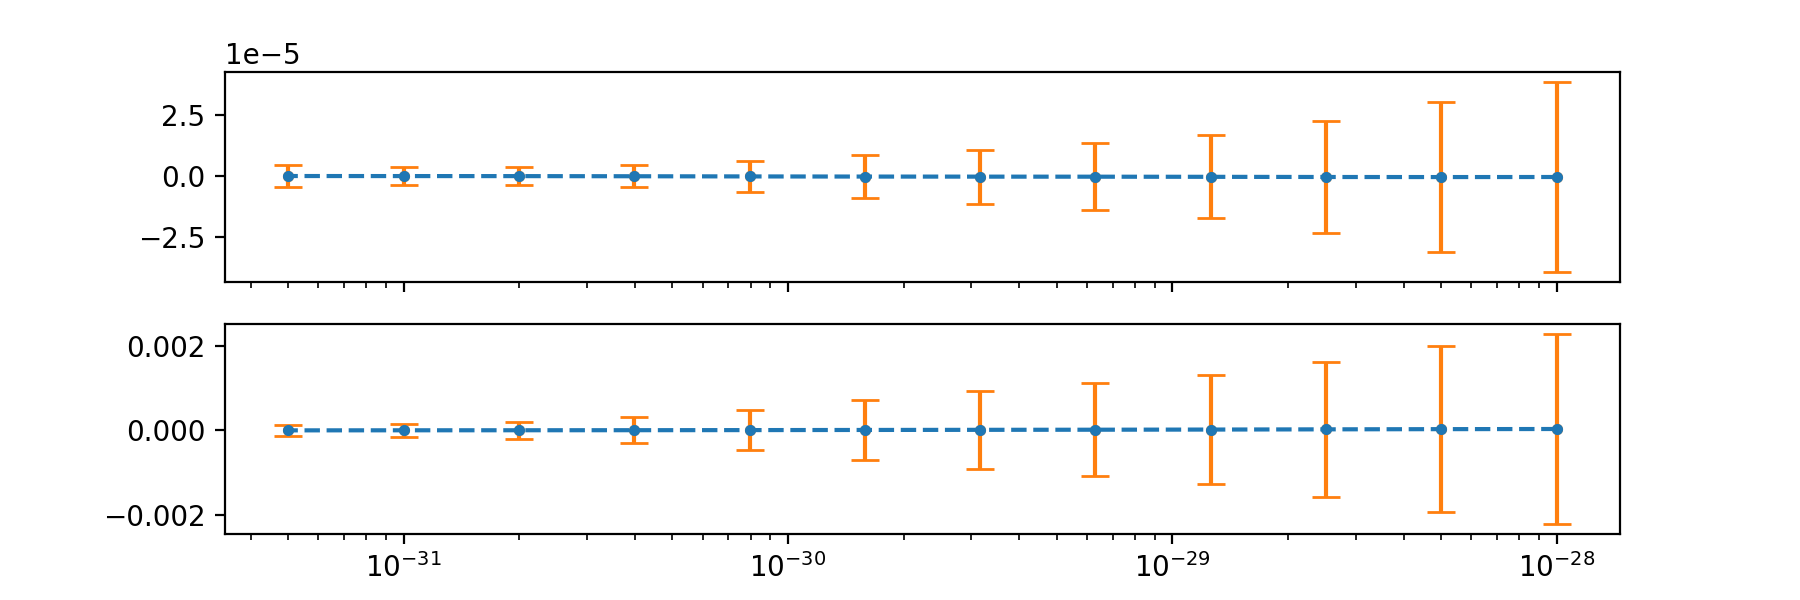

In [134]:
fig, ax = plt.subplots(2, 1, sharex=True)
for i_ord in range(extra.n_ord):
    mean_err = np.nanmean(err_bin_list[i_ord], axis=-1)
    std_err = np.nanstd(err_bin_list[i_ord], axis=-1)
    
    ax[i_ord].semilogx(tests["factors"][i_factor], mean_err, "--.")
    ax[i_ord].errorbar(tests["factors"][i_factor], mean_err, yerr=std_err/2, fmt=".", capsize=5., zorder=0)

<IPython.core.display.Javascript object>


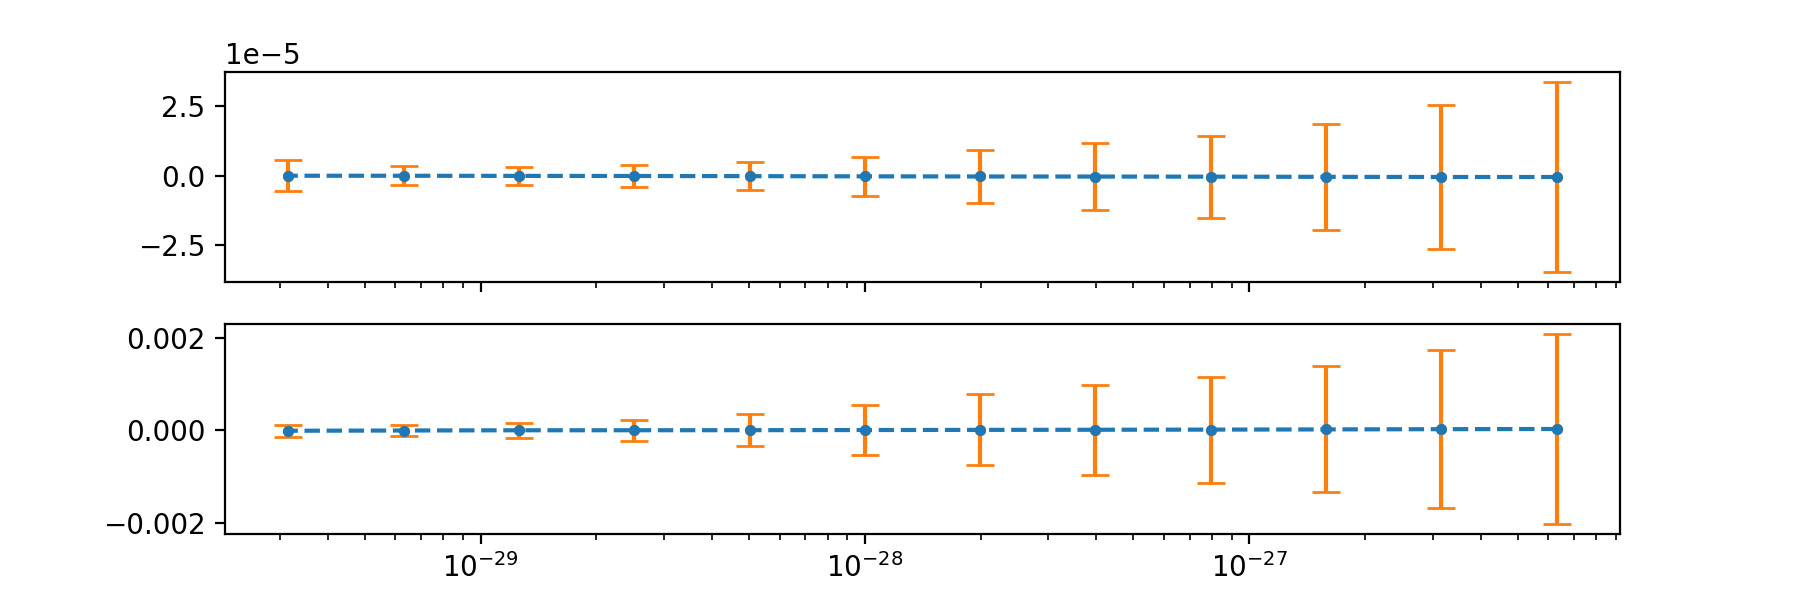

In [115]:
fig, ax = plt.subplots(2, 1, sharex=True)
for i_ord in range(extra.n_ord):
    mean_err = np.nanmean(err_bin_list[i_ord], axis=-1)
    std_err = np.nanstd(err_bin_list[i_ord], axis=-1)
    
    ax[i_ord].semilogx(tests["factors"][i_factor], mean_err, "--.")
    ax[i_ord].errorbar(tests["factors"][i_factor], mean_err, yerr=std_err/2, fmt=".", capsize=5., zorder=0)

### To better estimate the error, we can run a set of simulations with varying noise and compute the standard deviation

In [11]:
f_bin_list = [[] for i_ord in range(extra.n_ord)]
lam_bin = [None for i_ord in range(extra.n_ord)]

for it in range(30):
    print(it, end="\r")
    
    data = add_noise(simu_clean["data"])
    sig = np.sqrt(scidata + 20.**2)  # Map of expected noise
    
    f_k = extra.extract(data=data, sig=sig, tikhonov=True,
                        factor=5.78e-24)
    
    for i_ord in range(extra.n_ord):
        if it == 0:
            lam_bin_ord, f_bin = extra.bin_to_pixel(f_k=f_k, i_ord=i_ord)
            lam_bin[i_ord] = lam_bin_ord
        else:
            _, f_bin = extra.bin_to_pixel(f_k=f_k, i_ord=i_ord, grid_pix=lam_bin[i_ord])
        
        f_bin_list[i_ord].append(f_bin)
        
print("Done")

Done


<IPython.core.display.Javascript object>


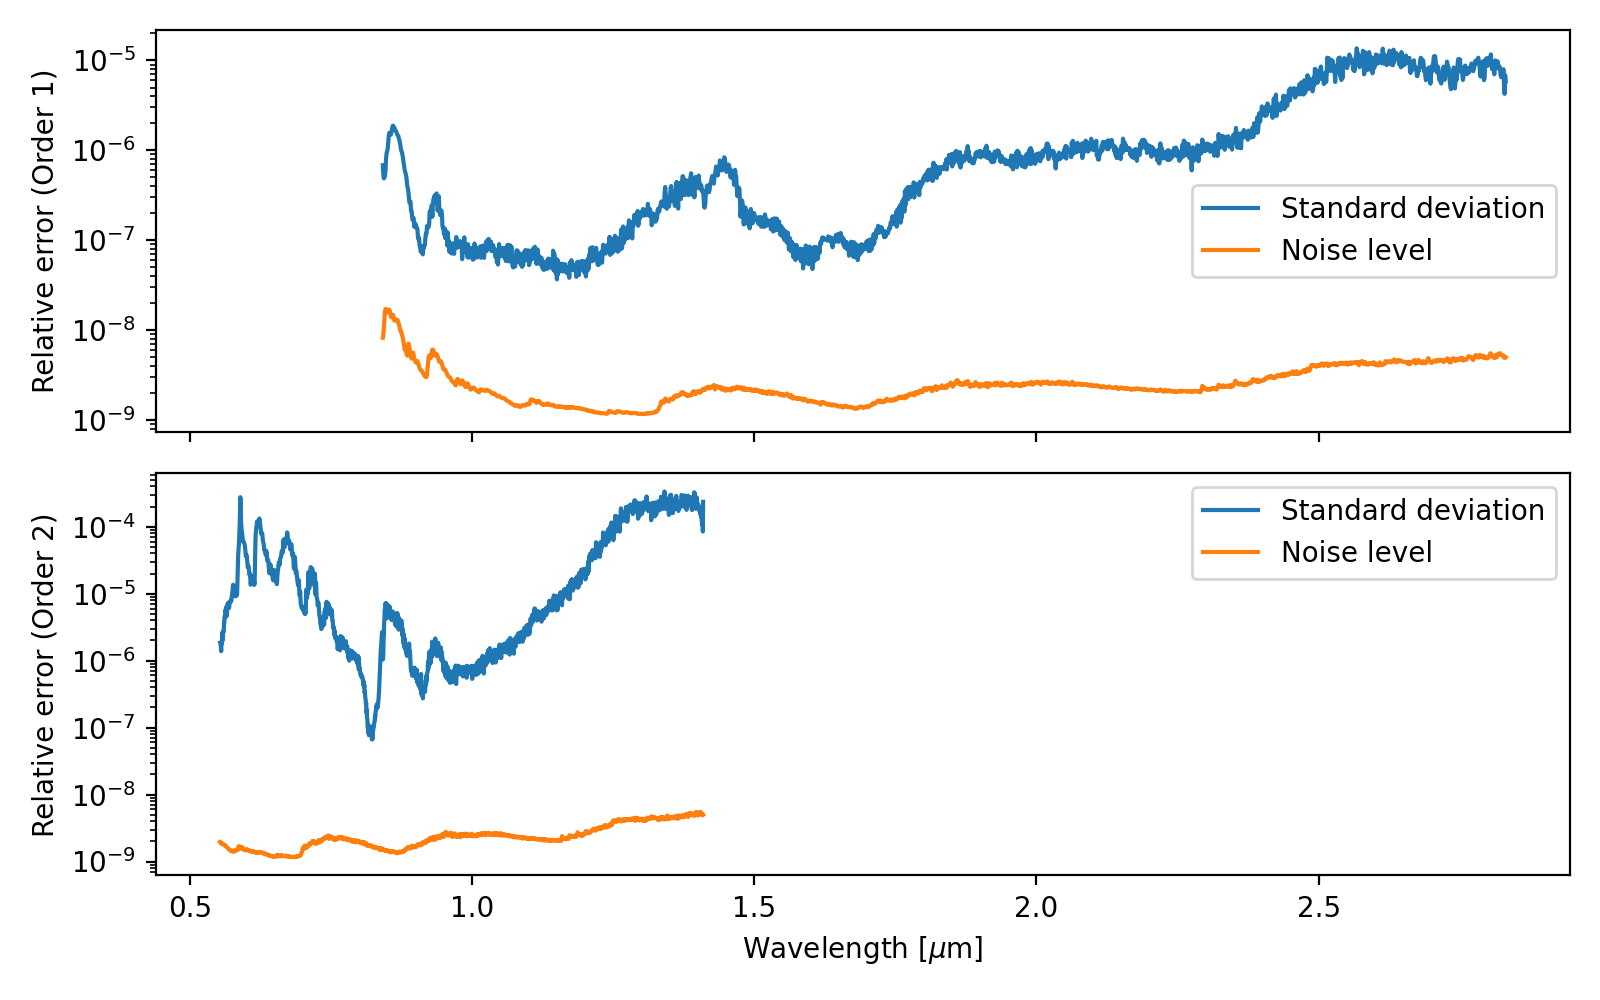

In [172]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

for i_ord in range(extra.n_ord):
    error =  np.std(f_bin_list[i_ord], axis=0) / np.mean(f_bin_list[i_ord], axis=0)
    ax[i_ord].semilogy(lam_bin[i_ord], error, label="Standard deviation")
    ax[i_ord].semilogy(*extra.estim_noise(i_ord=i_ord), label="Noise level")
    ax[i_ord].set_ylabel(f"Relative error (Order {i_ord + 1})")
    ax[i_ord].legend()
    
plt.xlabel("Wavelength [$\mu$m]")
plt.tight_layout()

<IPython.core.display.Javascript object>


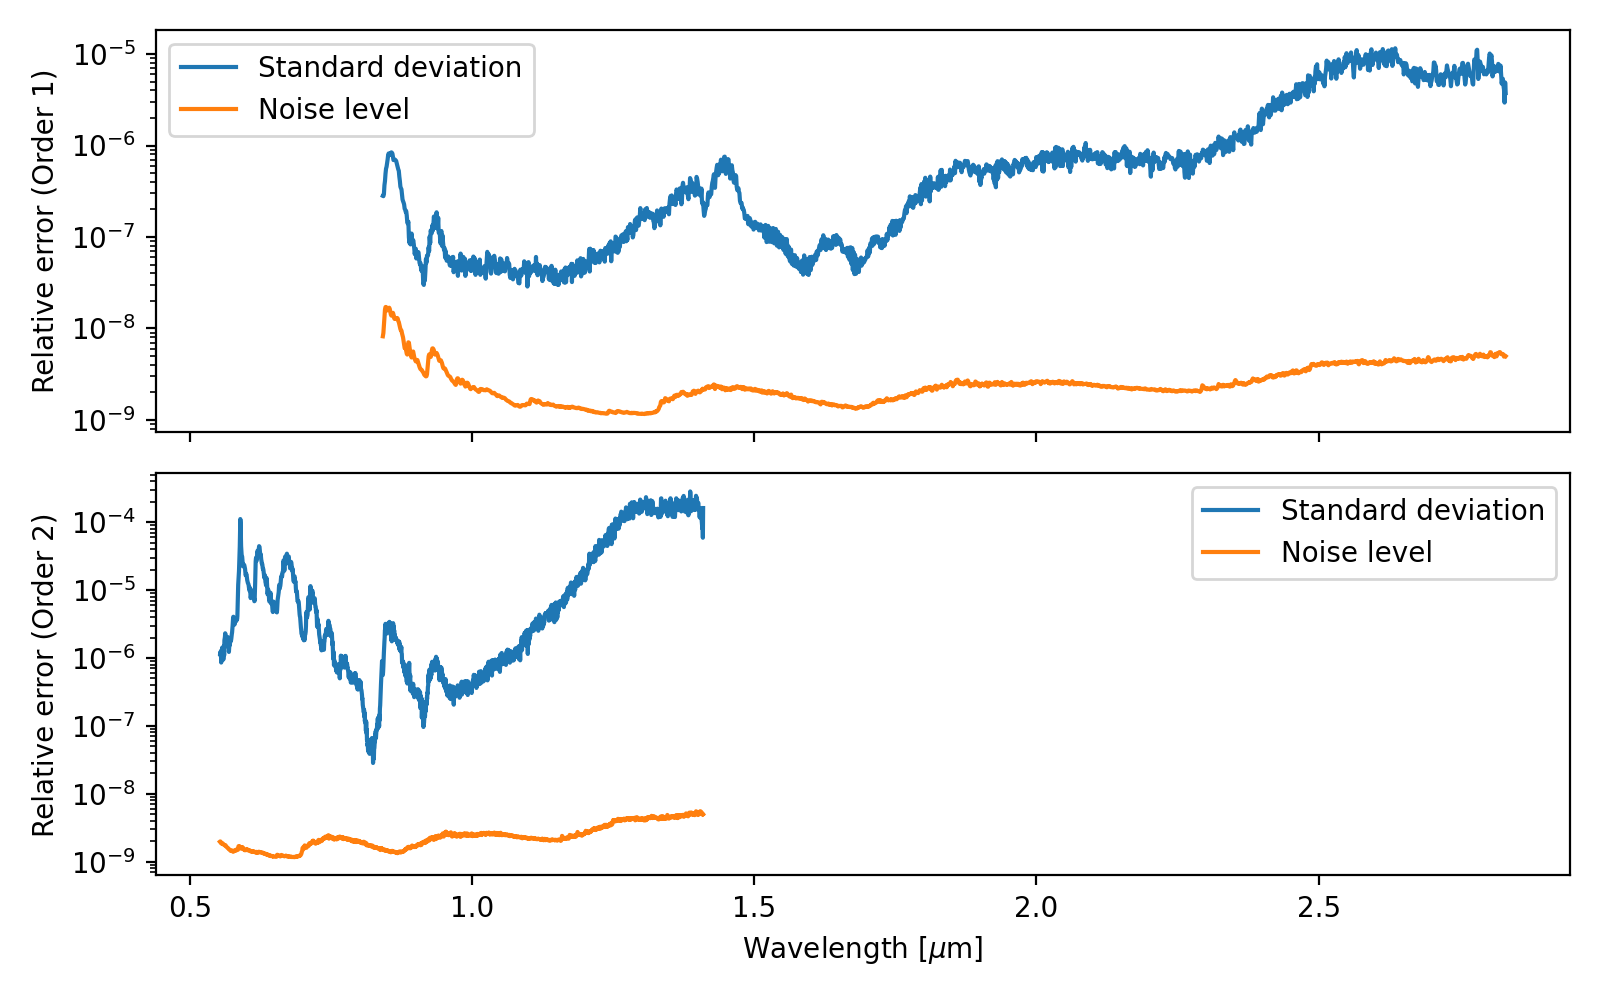

In [136]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

for i_ord in range(extra.n_ord):
    error =  np.std(f_bin_list[i_ord], axis=0) / np.mean(f_bin_list[i_ord], axis=0)
    ax[i_ord].semilogy(lam_bin[i_ord], error, label="Standard deviation")
    ax[i_ord].semilogy(*extra.estim_noise(i_ord=i_ord), label="Noise level")
    ax[i_ord].set_ylabel(f"Relative error (Order {i_ord + 1})")
    ax[i_ord].legend()
    
plt.xlabel("Wavelength [$\mu$m]")
plt.tight_layout()

## How much does the choice of the factor influences the result (binned)

In [173]:
factor_range = [np.log10(4e-30), np.log10(2e-29)]
factors = np.random.rand(30) * np.diff(factor_range)[0] + factor_range[0]
factors = 10.**factors
tests = extra.get_tikho_tests(factors, t_mat=t_mat)

Testing factors...
30/30


In [174]:
i_factor = np.ones_like(tests["factors"]).astype(bool)# (1e-20 < tests["factors"]) & (tests["factors"] < 1e-18)
print("N factor: ", i_factor.sum())

N factor:  30


In [175]:
f_k_list = tests["solution"][i_factor, :]
f_bin_list = [[] for i_ord in range(extra.n_ord)]
lam_bin = [None for i_ord in range(extra.n_ord)]

for i_ord in range(extra.n_ord):
    ifirst = True
    for f_k in f_k_list:
        f_k_c = extra.c_list[i_ord][:, tests["i_grid"]].dot(f_k)
        if ifirst:
            lam_bin_ord, f_bin = extra.bin_to_pixel(f_k_c=f_k_c, i_ord=i_ord)
            lam_bin[i_ord] = lam_bin_ord
            ifirst = False
        else:
            _, f_bin = extra.bin_to_pixel(f_k_c=f_k_c, i_ord=i_ord, grid_pix=lam_bin[i_ord])
            
        f_bin_list[i_ord].append(f_bin)

<IPython.core.display.Javascript object>


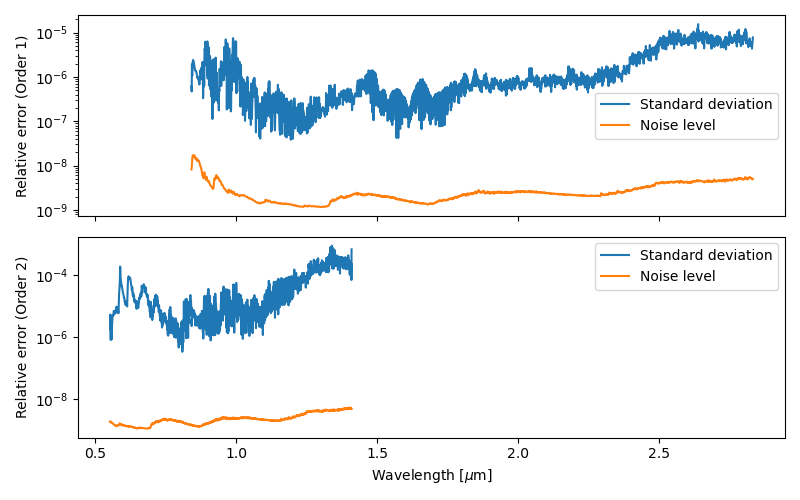

In [176]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

for i_ord in range(extra.n_ord):
    error =  np.std(f_bin_list[i_ord], axis=0) / np.mean(f_bin_list[i_ord], axis=0)
    ax[i_ord].semilogy(lam_bin[i_ord], error, label="Standard deviation")
    ax[i_ord].semilogy(*extra.estim_noise(i_ord=i_ord), label="Noise level")
    ax[i_ord].set_ylabel(f"Relative error (Order {i_ord + 1})")
    ax[i_ord].legend()
    
plt.xlabel("Wavelength [$\mu$m]")
plt.tight_layout()

<IPython.core.display.Javascript object>


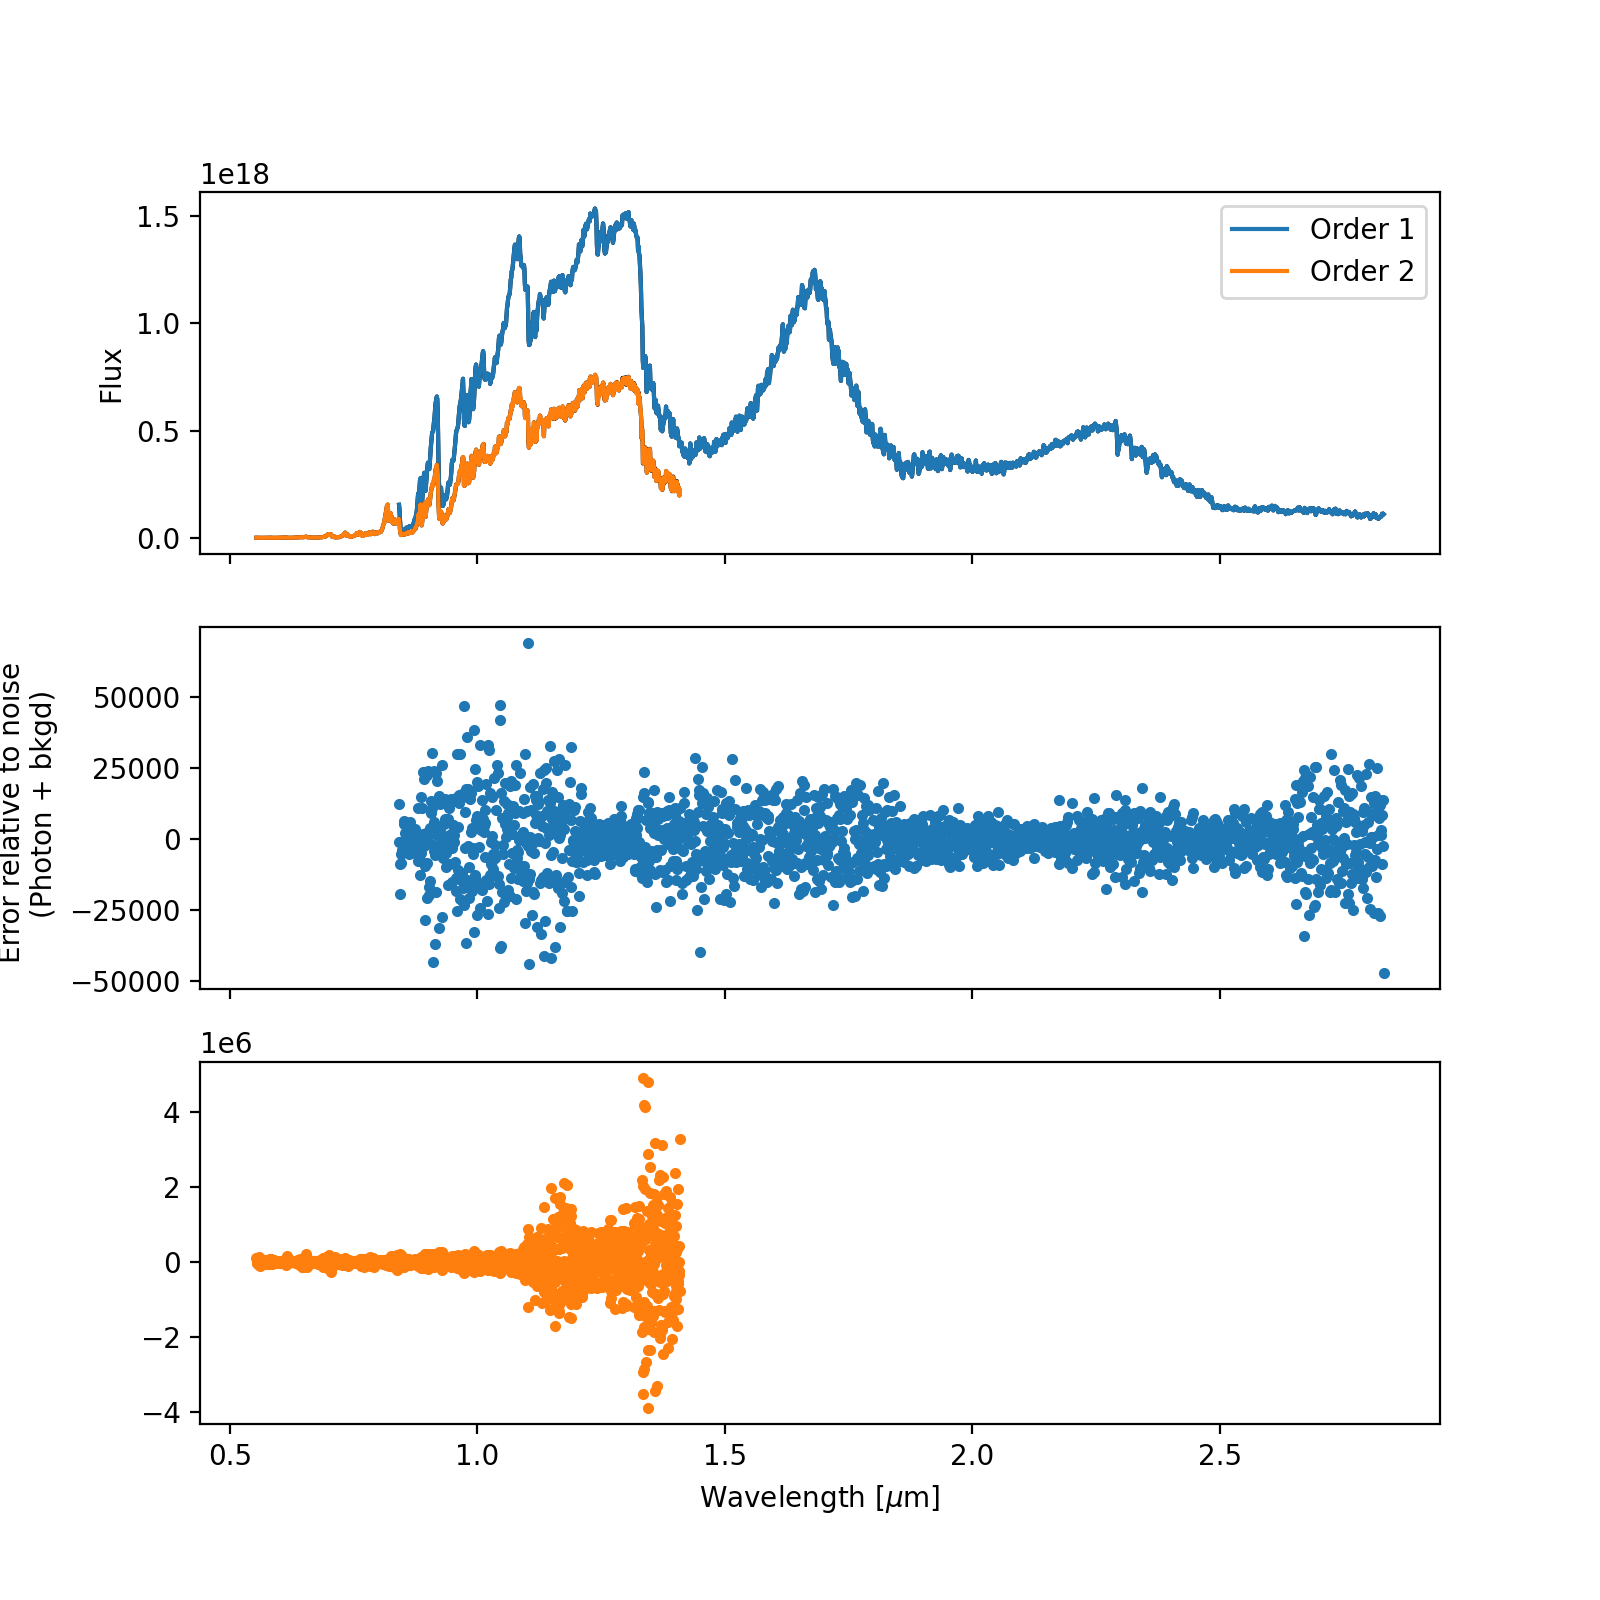

<IPython.core.display.Javascript object>


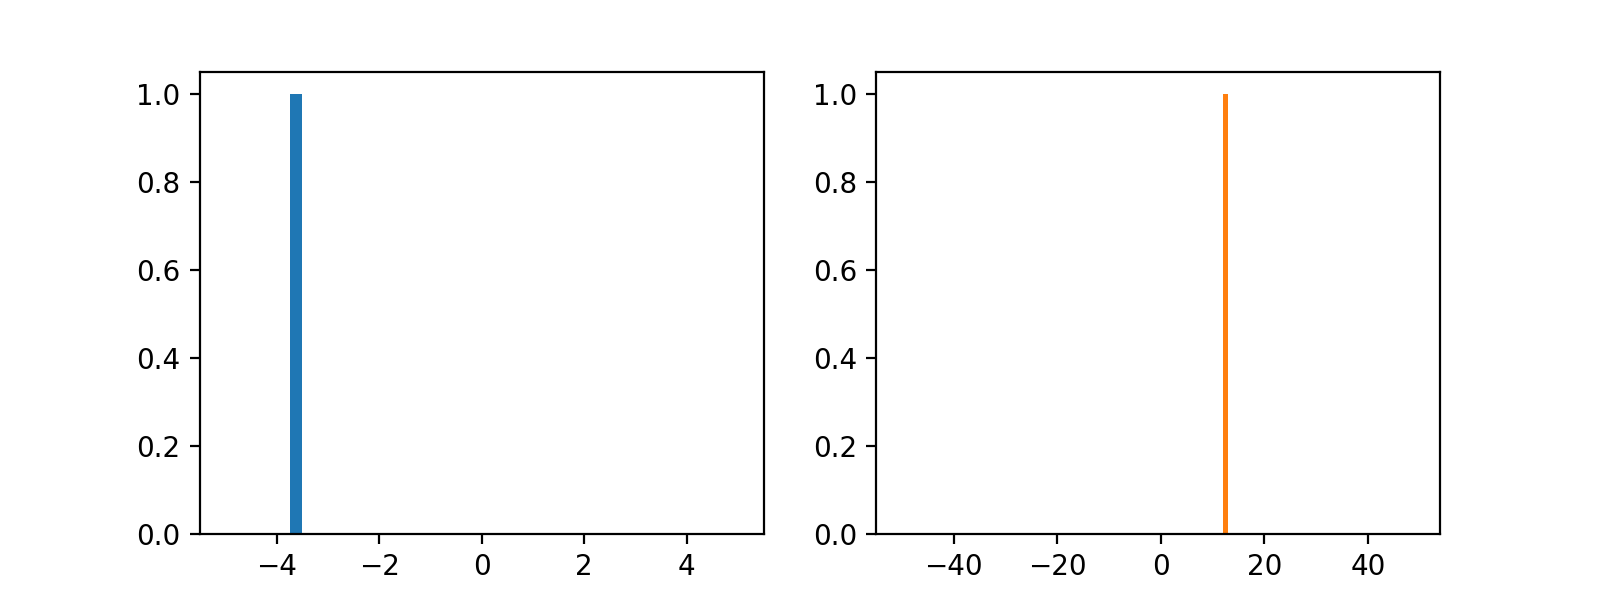

Text(0.5, 0, 'Wavelength [$\\mu$m]')

In [152]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

fig_bin, ax_bin = plt.subplots(1, 2, figsize=(8, 3))
bin_lim = [np.arange(-5, 5.2, 0.25), np.arange(-50, 50, 1)]

for i_ord in range(extra.n_ord):

    f_bin_mean = np.mean(f_bin_list[i_ord], axis=0)
    
    f_k_th = simu[f"f_c{i_ord + 1}"]
    grid_th = simu[f"grid_c{i_ord + 1}"]
    f_th_bin = extra.bin_to_pixel(f_k_c=f_k_th, grid_f_k=grid_th, grid_pix=lam_bin[i_ord])[1]
    bin_err = interp1d(*extra.estim_noise(i_ord=i_ord), bounds_error=False)
    
    ax[0].plot(lam_bin[i_ord], f_th_bin, "k")
    ax[0].plot(lam_bin[i_ord], f_bin_mean, label=f"Order {i_ord + 1}")

    color = ax[0].get_lines()[-1].get_color()
    ax[1+i_ord].plot(lam_bin[i_ord], (f_bin_mean-f_th_bin)/f_th_bin/bin_err(lam_bin[i_ord]), ".", color=color)
    
    ax_bin[i_ord].hist((f_bin_mean-f_th_bin)/f_th_bin/bin_err(lam_bin[i_ord]), bins=bin_lim[i_ord], color=color)    

ax[0].legend()
ax[0].set_ylabel("Flux")
ax[1].set_ylabel("Error relative to noise \n (Photon + bkgd)")
ax[-1].set_xlabel("Wavelength [$\mu$m]")

### Is the convolved flux closer to solution?

In [272]:
f_k_list = tests["solution"][i_factor, :]
f_k_c_list = [[] for i_ord in range(extra.n_ord)]

for i_ord in range(extra.n_ord):
    for f_k in f_k_list:
        f_k_c_list[i_ord].append(extra.c_list[i_ord][:, tests["i_grid"]].dot(f_k))

In [274]:
mean_f_k_c = [np.nanmean(f_k_c_list[i_ord], axis=0) for i_ord in range(extra.n_ord)]
std_f_k_c = [np.nanstd(f_k_c_list[i_ord], axis=0) for i_ord in range(extra.n_ord)]

<IPython.core.display.Javascript object>


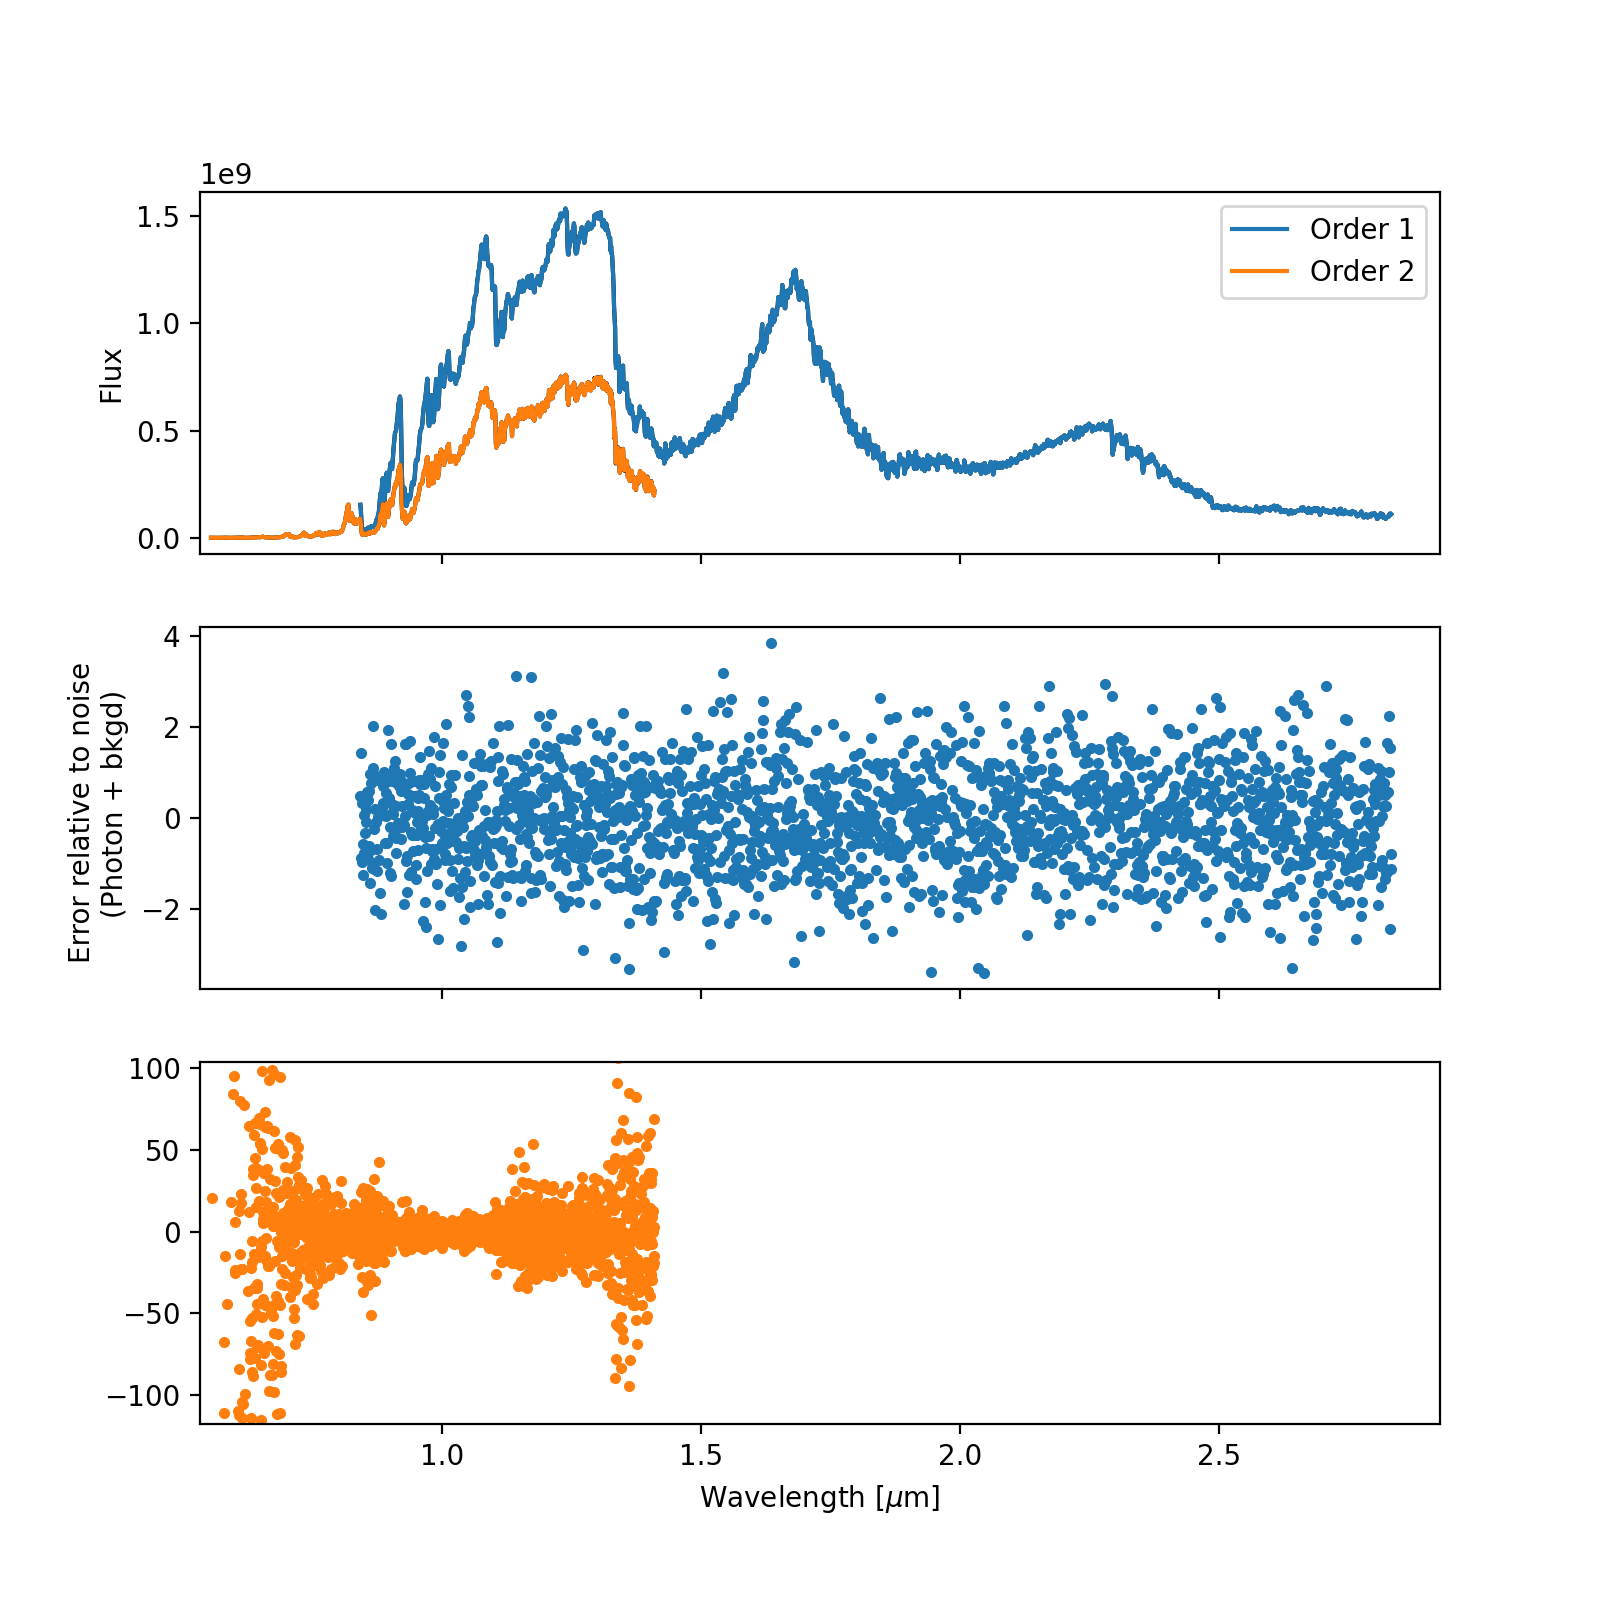

Text(0.5, 0, 'Wavelength [$\\mu$m]')

In [282]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

for i_ord in range(extra.n_ord):

    lam_bin_ord, f_bin = extra.bin_to_pixel(f_k_c=mean_f_k_c[i_ord], i_ord=i_ord)
    f_k_th = simu[f"f_c{i_ord + 1}"]
    grid_th = simu[f"grid_c{i_ord + 1}"]
    f_th_bin = extra.bin_to_pixel(f_k_c=f_k_th, grid_f_k=grid_th, grid_pix=lam_bin_ord)[1]
    bin_err = interp1d(*extra.estim_noise(i_ord=i_ord), bounds_error=False)
    
    ax[0].plot(lam_bin_ord, f_th_bin, "k")
    ax[0].plot(lam_bin_ord, f_bin, label=f"Order {i_ord + 1}")

    color = ax[0].get_lines()[-1].get_color()
    ax[1+i_ord].plot(lam_bin_ord, (f_bin-f_th_bin)/f_th_bin/bin_err(lam_bin_ord), ".", color=color)
    
ax[0].legend()
ax[0].set_ylabel("Flux")
ax[1].set_ylabel("Error relative to noise \n (Photon + bkgd)")
ax[-1].set_xlabel("Wavelength [$\mu$m]")